# Gmail vs Calendar Query Classifier using BERT
# -----------------------------------------------------------
# This notebook builds a text classification model using BERT to differentiate between Gmail-related and Calendar-related queries.
# It includes model training, evaluation, date extraction, and a Streamlit interface.

In [7]:
# STEP 1: Install dependencies
!pip install transformers datasets scikit-learn torch --quiet
!python -m spacy download en_core_web_sm


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ------------------ --------------------- 6.0/12.8 MB 30.7 MB/s eta 0:00:01
     ---------------------------------- ---- 11.3/12.8 MB 28.2 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 23.6 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [8]:
# STEP 2: Import necessary libraries
import os
os.environ["USE_TF"] = "0"  # Disable TensorFlow in Transformers to avoid tf_keras issue
import pandas as pd
import torch
import spacy
import re
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [9]:
# STEP 3: Build a diverse dataset
# We define a dataset with clear and ambiguous Gmail/Calendar queries.
# This helps train the model to generalize and disambiguate better.
#Dataset has been revised 3times aiming for better generalization
def build_dataset():
    raw_data = [
    # Gmail
    ("Find emails with PDF attachments", "gmail"),
    ("Show me unread messages in my inbox", "gmail"),
    ("Search for emails from Sarah about the project proposal", "gmail"),
    ("Find messages with the label 'Urgent'", "gmail"),
    ("What are the latest emails from HR?", "gmail"),
    ("Get emails that mention 'meeting notes'", "gmail"),
    ("Retrieve my conversation with Alex about the trip", "gmail"),
    ("Check if I got any emails with invoices", "gmail"),
    ("What did Sarah say in the email about budget?", "gmail"),
    ("Emails flagged as important", "gmail"),
    ("Do I have any mail from John regarding the party?", "gmail"),

    # Calendar
    ("When is my next meeting with the design team?", "calendar"),
    ("Find appointments with Dr. Johnson", "calendar"),
    ("Show me all-day events in May", "calendar"),
    ("When is the team lunch scheduled for?", "calendar"),
    ("Add a meeting with Rahul tomorrow at 3 PM", "calendar"),
    ("Check my schedule for next week", "calendar"),
    ("Do I have any events on the weekend?", "calendar"),
    ("List all recurring events", "calendar"),
    ("Find my meetings for June 2025", "calendar"),
    ("What is on my calendar today?", "calendar"),
    ("Am I free on Friday after 5 PM?", "calendar"),
    ("Schedule a doctor appointment on Tuesday", "calendar"),
    ("Add internship interview to my calendar", "calendar"),
    ("Remind me of monthly review call", "calendar"),
    ("Calendar for October travel plans", "calendar"),
    ("Plan all events for next quarter", "calendar"),
    ("Do I have a client call this afternoon?", "calendar"),
    ("Show all my meetings for the upcoming week", "calendar"),
    ("What’s planned in my calendar tomorrow?", "calendar"),
    ("Are there any events overlapping on Wednesday?", "calendar"),
    ("Get me the agenda for next Friday’s calendar", "calendar"),
    ("Do I have any one-on-ones this month?", "calendar"),
    ("Show my calendar entries tagged 'important'", "calendar"),
    ("Block time for deep work next Thursday", "calendar"),
    ("Reschedule my product demo to Tuesday", "calendar"),
    ("List meetings scheduled with the marketing team", "calendar"),
    ("Check if I'm double-booked tomorrow", "calendar"),

    # Ambiguous / Edge Cases
    ("Remind me what Sarah said about the meeting", "gmail"),
    ("Remind me about the meeting with Sarah", "calendar"),
    ("Did Sarah confirm the appointment?", "calendar"),
    ("What did the email say about the upcoming event?", "gmail"),
    ("Search my calendar for budget discussions", "calendar"),
    ("Get the latest messages from Dr. Johnson", "gmail"),
    ("Tell me about the event in yesterday's email", "gmail"),
    ("Was there an event scheduled after the last email?", "calendar"),
    ("Find the notes from yesterday", "gmail"),
    ("What did Alex plan for Friday?", "calendar")
    ]

    df = pd.DataFrame(raw_data, columns=["query", "label"])
    df['label'] = df['label'].map({'gmail': 0, 'calendar': 1})
    return df

df = build_dataset()

In [10]:
# STEP 4: Define Dataset class for tokenized inputs
class QueryDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [14]:
# STEP 5: Training and evaluation logic for each fold
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

def train_eval_model(model_name, tokenizer, train_idx, val_idx, df):
    train_texts = df.iloc[train_idx]['query'].tolist()
    train_labels = df.iloc[train_idx]['label'].tolist()
    val_texts = df.iloc[val_idx]['query'].tolist()
    val_labels = df.iloc[val_idx]['label'].tolist()

    train_encodings = tokenizer(train_texts, truncation=True, padding=True)
    val_encodings = tokenizer(val_texts, truncation=True, padding=True)

    train_dataset = QueryDataset(train_encodings, train_labels)
    val_dataset = QueryDataset(val_encodings, val_labels)

    from torch.utils.data import DataLoader
    from torch.optim import AdamW
    from tqdm import tqdm
    from torch.nn import CrossEntropyLoss

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    optimizer = AdamW(model.parameters(), lr=2e-5)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=4)
    loss_fn = CrossEntropyLoss(weight=torch.tensor([1.5, 2]).to(device))

    #Training
    model.train()
    for epoch in range(4):
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
        for batch in loop:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    #Evaluation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    #Evaluation metrics
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["gmail", "calendar"]))

    #Confusion matrix plot
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["gmail", "calendar"], yticklabels=["gmail", "calendar"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix')
    plt.show()

    return acc, f1



===== Fold 1 =====


C:\Users\antil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.09it/s]


Accuracy: 0.9000
F1 Score: 0.8967

Classification Report:
               precision    recall  f1-score   support

       gmail       1.00      0.75      0.86         4
    calendar       0.86      1.00      0.92         6

    accuracy                           0.90        10
   macro avg       0.93      0.88      0.89        10
weighted avg       0.91      0.90      0.90        10



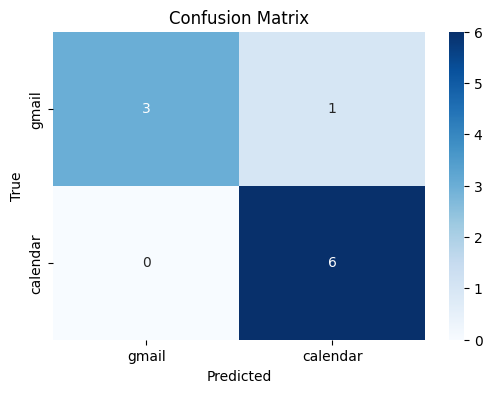


===== Fold 2 =====


C:\Users\antil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.13it/s]


Accuracy: 0.9000
F1 Score: 0.9033

Classification Report:
               precision    recall  f1-score   support

       gmail       0.75      1.00      0.86         3
    calendar       1.00      0.86      0.92         7

    accuracy                           0.90        10
   macro avg       0.88      0.93      0.89        10
weighted avg       0.93      0.90      0.90        10



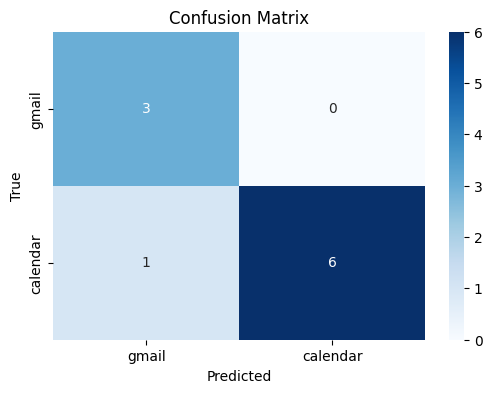


===== Fold 3 =====


C:\Users\antil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.09it/s]


Accuracy: 0.9000
F1 Score: 0.8933

Classification Report:
               precision    recall  f1-score   support

       gmail       1.00      0.67      0.80         3
    calendar       0.88      1.00      0.93         7

    accuracy                           0.90        10
   macro avg       0.94      0.83      0.87        10
weighted avg       0.91      0.90      0.89        10



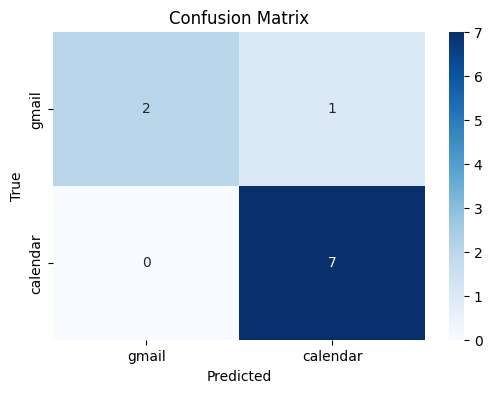


===== Fold 4 =====


C:\Users\antil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.11it/s]


Accuracy: 1.0000
F1 Score: 1.0000

Classification Report:
               precision    recall  f1-score   support

       gmail       1.00      1.00      1.00         3
    calendar       1.00      1.00      1.00         6

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



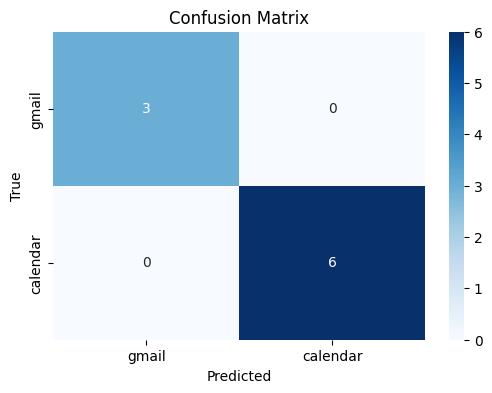


===== Fold 5 =====


C:\Users\antil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.03it/s]


Accuracy: 1.0000
F1 Score: 1.0000

Classification Report:
               precision    recall  f1-score   support

       gmail       1.00      1.00      1.00         3
    calendar       1.00      1.00      1.00         6

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



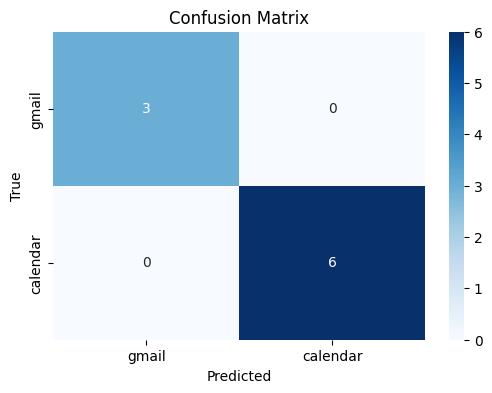


Final Average Accuracy: 0.9400
Final Average F1 Score: 0.9387


In [15]:
# STEP 6: Run K-Fold Cross Validation
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

accuracies = []
f1_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(df['query'], df['label'])):
    print(f"\n===== Fold {fold+1} =====")
    acc, f1 = train_eval_model(model_name, tokenizer, train_idx, val_idx, df)
    accuracies.append(acc)
    f1_scores.append(f1)

print(f"\nFinal Average Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Final Average F1 Score: {sum(f1_scores)/len(f1_scores):.4f}")